In [26]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
from ipyleaflet import *
import time
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins



%matplotlib inline

In [27]:
train = pd.read_csv("~/Documents/taxi_data/train.csv")

In [28]:
np.random.seed(2)
taxi = train.sample(frac=0.005, replace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7293 entries, 100879 to 1074490
Data columns (total 11 columns):
id                    7293 non-null object
vendor_id             7293 non-null int64
pickup_datetime       7293 non-null object
dropoff_datetime      7293 non-null object
passenger_count       7293 non-null int64
pickup_longitude      7293 non-null float64
pickup_latitude       7293 non-null float64
dropoff_longitude     7293 non-null float64
dropoff_latitude      7293 non-null float64
store_and_fwd_flag    7293 non-null object
trip_duration         7293 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 683.7+ KB


In [29]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
100879,id0673821,2,2016-03-19 20:53:44,2016-03-19 21:18:11,2,-73.990944,40.732998,-73.944931,40.774727,N,1467
203245,id3465534,2,2016-04-25 14:31:34,2016-04-25 14:37:05,2,-73.982185,40.752148,-73.988281,40.742992,N,331
1133010,id1354600,1,2016-05-04 16:35:10,2016-05-04 16:41:07,1,-73.969307,40.760986,-73.978966,40.747524,N,357
961799,id3014975,1,2016-01-16 10:41:51,2016-01-16 10:56:41,1,-73.986877,40.766727,-73.955513,40.826473,N,890
1102498,id0962434,1,2016-01-14 04:30:56,2016-01-14 04:34:37,1,-73.981865,40.758327,-73.991219,40.750141,N,221


# Feature relations

- 월별 trip_duration 평균

In [30]:
for i in range(len(taxi)):
    k = taxi['pickup_datetime'][i][5:7]
    taxi.at[i, "month"] = k 

KeyError: 0

In [ ]:
taxi_month = pd.DataFrame(taxi, columns=["month", "trip_duration"])
taxi_month = taxi_month.groupby('month').agg('mean').reset_index()

In [ ]:
taxi_month### 월별 평균 trip_duration

In [18]:
sns.barplot(taxi_month["month"], taxi_month["trip_duration"], palette='Set2')
plt.xlabel('month')
plt.ylabel('trip_duration')
plt.show()

ValueError: min() arg is an empty sequence

- 시간대별(00시~23시) trip_duration 평균

In [19]:
for i in range(len(taxi)):
    k = taxi['pickup_datetime'][i][11:13]
    taxi.at[i, "time"] = k  

KeyError: 0

In [20]:
taxi_time = pd.DataFrame(taxi, columns=["time", "trip_duration"])
taxi_time = taxi_time.groupby("time").agg("mean").reset_index()

In [21]:
taxi_time ### 시간대별 평균 trip_duration

,time,trip_duration


In [22]:
sns.barplot(taxi_time['time'], taxi_time['trip_duration'])
plt.xlabel('time')
plt.ylabel('trip_duration')
plt.show()

ValueError: min() arg is an empty sequence

- 요일별 trip_duration 평균

In [23]:
import calendar
for i in range(len(taxi)):
    m = taxi['pickup_datetime'][i][5:7]
    d = taxi['pickup_datetime'][i][8:10]
    k = calendar.weekday(2016, int(m), int(d))
    taxi.at[i, "week"] = k

KeyError: 0

In [24]:
taxi_week = pd.DataFrame(taxi, columns=['week','trip_duration'])
taxi_week = taxi_week.groupby('week').agg('mean').reset_index()

In [25]:
taxi_week ### 요일별 평균 trip_duration (0~6 : Mon~Sun)

,week,trip_duration


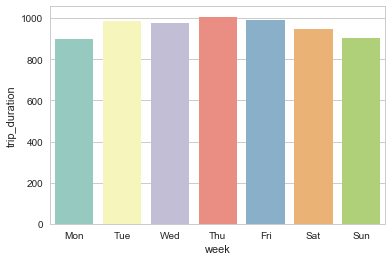

In [18]:
sns.barplot(taxi_week['week'], taxi_week['trip_duration'], palette='Set3')
plt.xlabel('week')
plt.xticks(taxi_week['week'], ('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.ylabel('trip_duration')
plt.show()

- store and flag별 평균 trip_duration

In [25]:
taxi_snf = pd.DataFrame(taxi, columns=['store_and_fwd_flag', 'trip_duration'])
taxi_snf = taxi_snf.groupby('store_and_fwd_flag').agg('mean').reset_index()

In [15]:
taxi_snf.groupby('store_and_fwd_flag').agg('mean').reset_index()

,store_and_fwd_flag,trip_duration
0,N,958.819706
1,Y,1080.763331


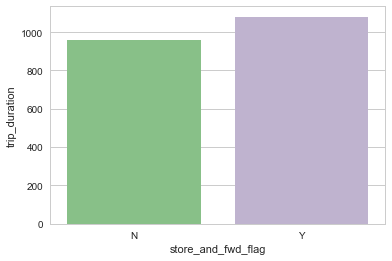

In [26]:
sns.barplot(taxi_snf['store_and_fwd_flag'], taxi_snf['trip_duration'], palette='Accent')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('trip_duration')
plt.show()

- passenger 수별 평균 trip_duration

> passenger 수가 0인 데이터 제외 (60개)

In [2]:
taxi.loc[taxi.passenger_count == 0] = np.NAN  
taxi = taxi.dropna(how= 'any')

In [35]:
taxi_passenger = pd.DataFrame(taxi, columns=['passenger_count', 'trip_duration'])
taxi_passenger = taxi_passenger.groupby('passenger_count').agg('mean').reset_index()

In [36]:
taxi_passenger.groupby('passenger_count').agg('mean').reset_index()

,passenger_count,trip_duration
0,1.0,930.399753
1,2.0,1005.458335
2,3.0,1028.236276
3,4.0,1053.529749
4,5.0,1070.232174
5,6.0,1061.355223
6,7.0,19.666667
7,8.0,104.000000
8,9.0,560.000000


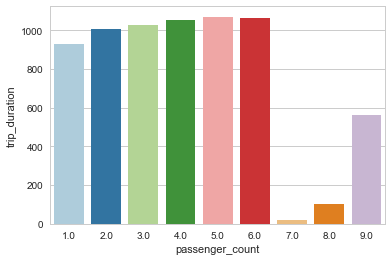

In [37]:
sns.barplot(taxi_passenger['passenger_count'], taxi_passenger['trip_duration'], palette='Paired')
plt.xlabel('passenger_count')
plt.ylabel('trip_duration')
plt.show()

# Direct distance of the trip

## 직선거리 구하기

In [8]:
## 직선거리 함수
from math import cos, asin, sqrt
def dist(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))


In [9]:
len(taxi)

7293

In [10]:
## distance 칼럼 추가
for i in range(len(taxi)):
    lat1 = taxi['pickup_latitude'][i]
    lon1 = taxi['pickup_longitude'][i]
    lat2 = taxi['dropoff_latitude'][i]
    lon2 = taxi['dropoff_longitude'][i]
    taxi.at[i, 'distance'] = dist(lat1, lon1, lat2, lon2)


KeyError: 0

In [45]:
taxi['distance'].max(), taxi['distance'].min()  ## 직선거리 최대, 최소

(1240.9086766508517, 0.0)

In [46]:
len(taxi.loc[taxi.distance == 0]) ## 직선거리가 0인 경우 (출발위치와 도착위치가 같은 경우)

5897

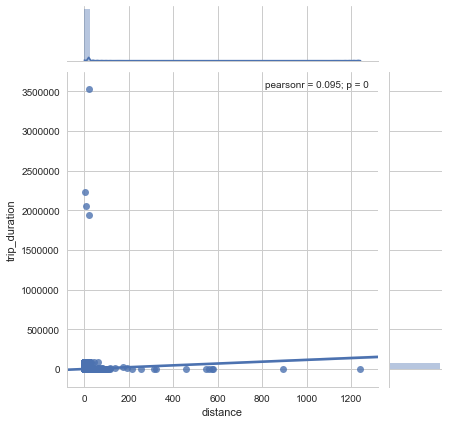

In [48]:
sns.jointplot(taxi['distance'], taxi['trip_duration'], kind = 'reg') ## distance와 trip_duration의 jointplot
plt.show()

In [51]:
40000/3600

11.11111111111111

In [52]:
taxi.loc[taxi.trip_duration > 30000] = np.nan ##40000초(약 11시간)가 넘는 데이터 제거
taxi.dropna(inplace=True)

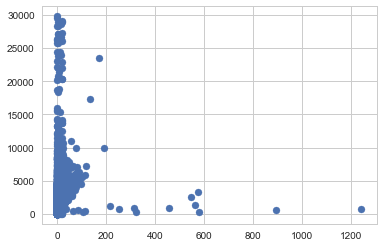

In [53]:
plt.scatter(taxi['distance'], taxi['trip_duration'])
plt.show()

> 4000초(약 1시간)이내에서 distance가 200km가 넘을 수 없다. ($\because$자동차 최대속도)

In [54]:
taxi.loc[taxi.distance > 200] = np.nan ##200km 넘는 데이터 제거
taxi.dropna(inplace=True)

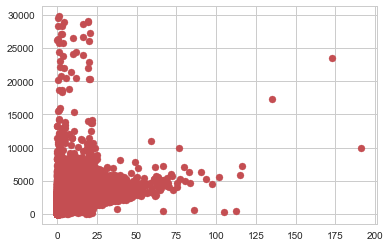

In [56]:
plt.scatter(taxi['distance'], taxi['trip_duration'], color = 'r')
plt.show()

In [72]:
len(taxi)

1456601

> 대부분의 데이터(1455220개)가 직선거리가 25km 이내이다. 따로 저장(taxi_2)

In [57]:
taxi_2 = taxi.loc[taxi.distance < 25]
len(taxi_2)

1455220

- pickup위치 scatterplot(위도, 경도)

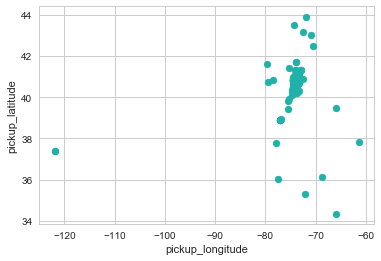

In [73]:
plt.scatter(taxi['pickup_longitude'], taxi['pickup_latitude'], color='lightseagreen')
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()


- dropoff위치 scatterplot(위도, 경도)

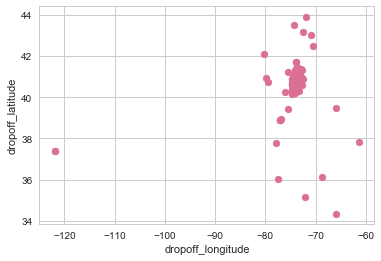

In [74]:
plt.scatter(taxi['dropoff_longitude'], taxi['dropoff_latitude'], color='palevioletred')
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

# leaflet visualization

In [2]:
from ipyleaflet import *
import pandas as pd

In [3]:
center = [40.767937, -73.982155]
zoom = 10
m = Map(center=center, zoom=zoom)

In [4]:
locs = list(zip(taxi['pickup_latitude'], taxi['pickup_longitude']))

In [ ]:
for loc in locs:
    marker = Marker(location=loc)
    m += marker
m


In [ ]:
locs_2 = list(zip(taxi['dropoff_latitude'], taxi['dropoff_longitude']))

In [ ]:
center = [40.767937, -73.982155]
zoom = 10
m_2 = Map(center=center, zoom=zoom)

In [ ]:
for loc in locs_2:
    marker = Marker(location=loc)
    m_2 += marker
m_2